2021.02.12

The following processes the amazon dataset from: https://www.kaggle.com/snap/amazon-fine-food-reviews

Original Data Size: 568454 x 10  
Final dataset size: 396295 x 7

For simplicity, I omitted the following columns:

* Id -- unique identifier, not helpful
* ProductId -- mostly unique identifier, not helpful
* UserId -- mostly unique identifier
* Time -- this is useful probably but unsure about datetime conversion in mindsdb right now
* Summary -- this is useful, but may enable a net to 'cheat' and not really use full-text data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%ls

amazon_preproc.ipynb  archive.zip  database.sqlite  hashes.txt  Reviews.csv


In [3]:
x = pd.read_csv('Reviews.csv')
print(x.shape)
x.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
x.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
# Convert date columns appropriately

dateCols = ['Time']
for col in dateCols:
    try:
        x[col] = pd.to_datetime(x[col])
    except ValueError:
        print(col, "cannot be converted to datetime")
        

Drop useless columns (for simplicity sake this is defined as columns with too many NaNs). By design, we will drop all identifiers, as these don't provide important information

In [6]:
def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%s' % str(round(height, 2))[:3],
                ha='center', va='bottom')

[Text(0, 0, 'Id'),
 Text(1, 0, 'ProductId'),
 Text(2, 0, 'UserId'),
 Text(3, 0, 'ProfileName'),
 Text(4, 0, 'HelpfulnessNumerator'),
 Text(5, 0, 'HelpfulnessDenominator'),
 Text(6, 0, 'Score'),
 Text(7, 0, 'Time'),
 Text(8, 0, 'Summary'),
 Text(9, 0, 'Text')]

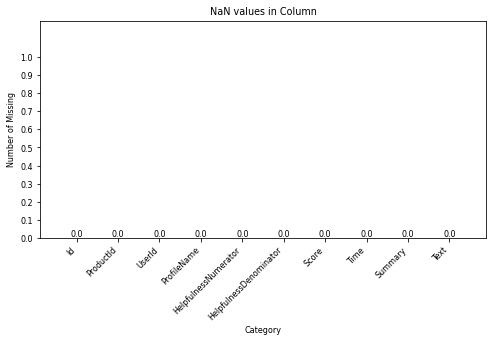

In [7]:
plt.rcParams['font.size'] = 8
# Check NaNs in each column - a priori drop the bad ones
fig, axes = plt.subplots(1,1, figsize=(8,4))
rect = axes.bar(x.columns, x.isna().sum()/x.shape[0])
autolabel(rect, axes)
axes.set_xlabel("Category")
axes.set_ylabel("Number of Missing")
axes.set_title("NaN values in Column")
axes.set_yticks(np.arange(0, 1.1, 0.1))
axes.set_ylim([0,1.2])
axes.set_xticks(range(len(x.columns)))
axes.set_xticklabels(x.columns, rotation=45, horizontalalignment="right")

No columns are useless! Great!

In [8]:
# Example row 
x.iloc[-1]

Id                                                                   568454
ProductId                                                        B001LR2CU2
UserId                                                       A3LGQPJCZVL9UC
ProfileName                                                        srfell17
HelpfulnessNumerator                                                      0
HelpfulnessDenominator                                                    0
Score                                                                     5
Time                                          1970-01-01 00:00:01.338422400
Summary                                                         Great Honey
Text                      I am very satisfied ,product is as advertised,...
Name: 568453, dtype: object

In [9]:
remove_cols = ["Id", "ProductId", "UserId", "Time"]
x = x[[col for col in x.columns if col not in remove_cols]]

print("Old shape = ", x.shape)
# Remove missing values
x = x.dropna(how='any') # Remove any NaNs; there are none for this example
x = x.drop_duplicates() # Remove any copied instances
print("New shape = ", x.shape)


Old shape =  (568454, 6)
New shape =  (396248, 6)


Picking a small subset - may open it up to a larger dataset

Predict the rating distribution; this is nice as it has non-negligible 1-3 star reviews.


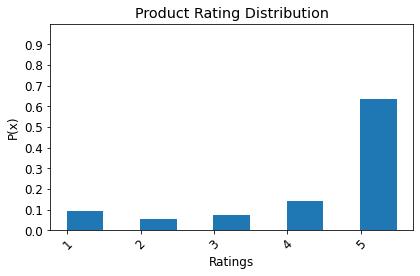

In [10]:
plt.rcParams['font.size']= 12
xticks = np.arange(1,6)

f, axes = plt.subplots(1,1, figsize=(6,4))
axes.hist(x["Score"],
          bins=np.arange(0.99, 5.5,0.5),
          weights=np.ones(x.shape[0])/x.shape[0])
axes.set_xlabel("Ratings")
axes.set_ylabel("P(x)")
axes.set_title("Product Rating Distribution")
axes.set_yticks(np.arange(0, 1, 0.1))
axes.set_ylim([0, 1])
axes.set_xticks(xticks)
#axes.set_xlim([0, 6])
axes.set_xticklabels([str(i) for i in xticks], rotation=45)
f.tight_layout()

In [11]:
# No Summary Data
cols1 = [col for col in x.columns if col != "Time"]
x[cols1].to_csv("data_nosummary.csv", index=False)

# Text only data
cols2 = [col for col in ["Text", "Score"]]
x[cols2].to_csv("data_textonly.csv", index=False)

# Dataset
x.to_csv("data_full.csv", index=False)

